# Challenge 1

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running locally


Import required libraries

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [3]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


Define some useful constants.

In [4]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/checkpoints' if is_running_on_kaggle() else 'checkpoints/'
FIGURES_DIR = '/kaggle/working/figures' if is_running_on_kaggle() else 'figures/'

SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 100 if is_running_on_kaggle() else 100

Set the manual seed.

In [5]:
torch.manual_seed(42)

Extend **Dataset** class for the **DatasetLoader** (define a mapping for images and labels).

In [6]:
from torchvision.io import read_image

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, transform_minority=None, target_transform=None, equalize=False):
        self.equalize = equalize
        if self.equalize:
            self.img_labels = self.equalize_dataset(annotations_file)
        else:
            self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.transform_minority = transform_minority

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            if label == 1:
                image = self.transform(image)
            else:
                image = self.transform_minority(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    def equalize_dataset(self, file):
        df = pd.read_csv(file)
        filtered_rows = df[df['has_cactus']==0]
        df = pd.concat([df, filtered_rows], ignore_index=True)
        df = pd.concat([df, filtered_rows], ignore_index=True)
        return df

TODO: Try to preprocess like in ImProc

Instanciate a **Dataset** object on the training (+validation) data.

In [7]:
# Imagenet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = [0.5035902857780457, 0.451941579580307, 0.4681771695613861]
std = [0.15118408203125, 0.1397838294506073, 0.15320344269275665]

In [8]:
import torchvision.transforms as transforms

# Transformation for the image data
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
])
transform_minority = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=np.random.uniform(0,30)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
    
])

In [9]:
# Create the dataset object
trainval_data = CactusDataset(ANNOTATIONS_FILE, IMG_DIR, transform=transform, transform_minority=transform_minority, equalize=True)

In [10]:
# Print the shape of the first image in the dataset
print(trainval_data[0][0].shape)

torch.Size([3, 32, 32])


Split the dataset into train + validation

In [11]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(trainval_data))
val_size = len(trainval_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

Training set size: 20982
Validation set size: 5246


Let's define our first model.\
We are going to use the ResNet18 pretrained model and then we are going to add 1 linear FC output layer. The output will be a real value that we will feed into a Sigmoid function to squash it into the $[0, 1]$ interval, and we will do the classification by comparing the output of the Sigmoid with the $0.5$ treshold.\
Since we don't want to adjust ResNet18 weights, we are going to set the **requires_grad** property to **False** for each of its parameters.

In [12]:
from torchvision.models import resnet18, ResNet18_Weights

class ResnetClassificator(nn.Module):
    def __init__(self, fc_size=None):
        super(ResnetClassificator, self).__init__()
        
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        
        self.resnet = resnet
        self.fc_size = 1 if fc_size is None or fc_size < 2 else fc_size
        if self.fc_size < 2:
            self.fc1 = nn.Linear(resnet.fc.out_features, 1)
        else:
            self.fc1 = nn.Linear(resnet.fc.out_features, fc_size)
            self.fc2 = nn.Linear(fc_size, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc1(x)
        if self.fc_size != 1:
            x = self.fc2(x)
        return x

At this point, let's train our model.

In [13]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [14]:
# Training loop (1 epoch)
def train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc='Training', dir_checkpoint=None):
    avg_train_loss = 0
    train_bar = tqdm(train_dataloader, desc=desc, leave=False)
    
    model.train()
    for X, y in train_bar:
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X.float())
        y = y.reshape(-1, 1).float()
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the average loss
        avg_train_loss += loss.item() * len(y)

        # Update the loading bar
        train_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = avg_train_loss / len(train_dataloader.dataset)
    train_bar.set_postfix({'loss': avg_train_loss})
    train_bar.close()

    if checkpoint:
        save_checkpoint(model, optimizer, avg_train_loss, dir_checkpoint, desc)

    return avg_train_loss

In [15]:
# Compute validation loss and error rate
def evaluate(val_dataloader, model, criterion, desc='Validation'):
    avg_val_loss = 0
    errors = []
    val_bar = tqdm(val_dataloader, desc=desc, leave=False)

    model.eval()
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for X, y in val_bar:
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            y = y.reshape(-1, 1).float()
            loss = criterion(pred, y)

            # Save errors for error rate
            pred = nn.Sigmoid()(pred) > 0.5

            tp += torch.bitwise_and(y == 1, pred == 1).sum().item()
            tn += torch.bitwise_and(y == 0, pred == 0).sum().item()
            fp += torch.bitwise_and(y == 0, pred == 1).sum().item()
            fn += torch.bitwise_and(y == 1, pred == 0).sum().item()

            errors += pred != y

            # Update the average loss
            avg_val_loss += loss.item() * len(y)

            # Update the loading bar
            val_bar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = avg_val_loss / len(val_dataloader.dataset)
    val_bar.set_postfix({'loss': avg_val_loss})
    val_bar.close()
    return avg_val_loss, errors, [[tp, fp], [fn, tn]]

In [16]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [17]:
def f1_score(confusion_matrix):
    tp, fp = confusion_matrix[0]
    fn, _ = confusion_matrix[1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * (precision * recall) / (precision + recall)

In [18]:
class CustomConvNet(torch.nn.Module):
    def __init__(self, fc_size, dropout):
        super(CustomConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, fc_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_size, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

>>>>>>>>     FC Size: 6 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1836 - Val Loss: 0.0780 - Error Rate: 0.0248 - F1 Score: 0.9755 - (FPR: 0.0263 - FNR: 0.0232)


Epoch 2/100	 Train Loss: 0.0949 - Val Loss: 0.0477 - Error Rate: 0.0149 - F1 Score: 0.9854 - (FPR: 0.0209 - FNR: 0.0086)


Epoch 3/100	 Train Loss: 0.0770 - Val Loss: 0.0421 - Error Rate: 0.0126 - F1 Score: 0.9876 - (FPR: 0.0172 - FNR: 0.0078)


Epoch 4/100	 Train Loss: 0.0565 - Val Loss: 0.0352 - Error Rate: 0.0122 - F1 Score: 0.9878 - (FPR: 0.0050 - FNR: 0.0194)


Epoch 5/100	 Train Loss: 0.0499 - Val Loss: 0.0299 - Error Rate: 0.0124 - F1 Score: 0.9876 - (FPR: 0.0019 - FNR: 0.0226)


Epoch 6/100	 Train Loss: 0.0399 - Val Loss: 0.0202 - Error Rate: 0.0078 - F1 Score: 0.9922 - (FPR: 0.0027 - FNR: 0.0130)


Epoch 7/100	 Train Loss: 0.0365 - Val Loss: 0.0262 - Error Rate: 0.0101 - F1 Score: 0.9899 - (FPR: 0.0015 - FNR: 0.0185)


Epoch 8/100	 Train Loss: 0.0296 - Val Loss: 0.0127 - Error Rate: 0.0042 - F1 Score: 0.9959 - (FPR: 0.0049 - FNR: 0.0035)


Epoch 9/100	 Train Loss: 0.0240 - Val Loss: 0.0136 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0027 - FNR: 0.0058)


Epoch 10/100	 Train Loss: 0.0233 - Val Loss: 0.0217 - Error Rate: 0.0074 - F1 Score: 0.9927 - (FPR: 0.0094 - FNR: 0.0054)


Epoch 11/100	 Train Loss: 0.0223 - Val Loss: 0.0091 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0015 - FNR: 0.0038)


Epoch 12/100	 Train Loss: 0.0167 - Val Loss: 0.0084 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0019 - FNR: 0.0031)


Epoch 13/100	 Train Loss: 0.0146 - Val Loss: 0.0103 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0026 - FNR: 0.0031)


Epoch 14/100	 Train Loss: 0.0177 - Val Loss: 0.0210 - Error Rate: 0.0063 - F1 Score: 0.9937 - (FPR: 0.0000 - FNR: 0.0125)


Epoch 15/100	 Train Loss: 0.0160 - Val Loss: 0.0172 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0000 - FNR: 0.0084)


Epoch 16/100	 Train Loss: 0.0122 - Val Loss: 0.0110 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0041 - FNR: 0.0027)


Epoch 17/100	 Train Loss: 0.0114 - Val Loss: 0.0135 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0030 - FNR: 0.0042)


Epoch 18/100	 Train Loss: 0.0103 - Val Loss: 0.0085 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0011 - FNR: 0.0046)


Epoch 19/100	 Train Loss: 0.0103 - Val Loss: 0.0134 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0053 - FNR: 0.0027)


Epoch 20/100	 Train Loss: 0.0086 - Val Loss: 0.0149 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0004 - FNR: 0.0080)


Epoch 21/100	 Train Loss: 0.0098 - Val Loss: 0.0215 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0008 - FNR: 0.0095)


Epoch 22/100	 Train Loss: 0.0110 - Val Loss: 0.0227 - Error Rate: 0.0057 - F1 Score: 0.9943 - (FPR: 0.0000 - FNR: 0.0114)


Epoch 23/100	 Train Loss: 0.0099 - Val Loss: 0.0077 - Error Rate: 0.0017 - F1 Score: 0.9983 - (FPR: 0.0004 - FNR: 0.0031)


Epoch 24/100	 Train Loss: 0.0075 - Val Loss: 0.0397 - Error Rate: 0.0109 - F1 Score: 0.9891 - (FPR: 0.0000 - FNR: 0.0215)


Epoch 25/100	 Train Loss: 0.0082 - Val Loss: 0.0057 - Error Rate: 0.0019 - F1 Score: 0.9981 - (FPR: 0.0008 - FNR: 0.0031)


Epoch 26/100	 Train Loss: 0.0050 - Val Loss: 0.0112 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0026 - FNR: 0.0027)


Epoch 27/100	 Train Loss: 0.0061 - Val Loss: 0.0378 - Error Rate: 0.0097 - F1 Score: 0.9905 - (FPR: 0.0185 - FNR: 0.0004)


Epoch 28/100	 Train Loss: 0.0088 - Val Loss: 0.0069 - Error Rate: 0.0015 - F1 Score: 0.9985 - (FPR: 0.0004 - FNR: 0.0027)


Epoch 29/100	 Train Loss: 0.0067 - Val Loss: 0.0106 - Error Rate: 0.0019 - F1 Score: 0.9981 - (FPR: 0.0000 - FNR: 0.0038)


Epoch 30/100	 Train Loss: 0.0078 - Val Loss: 0.0289 - Error Rate: 0.0082 - F1 Score: 0.9918 - (FPR: 0.0023 - FNR: 0.0141)


Epoch 31/100	 Train Loss: 0.0086 - Val Loss: 0.0205 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0000 - FNR: 0.0110)


Epoch 32/100	 Train Loss: 0.0105 - Val Loss: 0.0108 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0011 - FNR: 0.0046)


Epoch 33/100	 Train Loss: 0.0039 - Val Loss: 0.0144 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0004 - FNR: 0.0050)


Epoch 34/100	 Train Loss: 0.0040 - Val Loss: 0.0080 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0000 - FNR: 0.0042)


Epoch 35/100	 Train Loss: 0.0032 - Val Loss: 0.0071 - Error Rate: 0.0017 - F1 Score: 0.9983 - (FPR: 0.0000 - FNR: 0.0035)
Early stopping on epoch 35


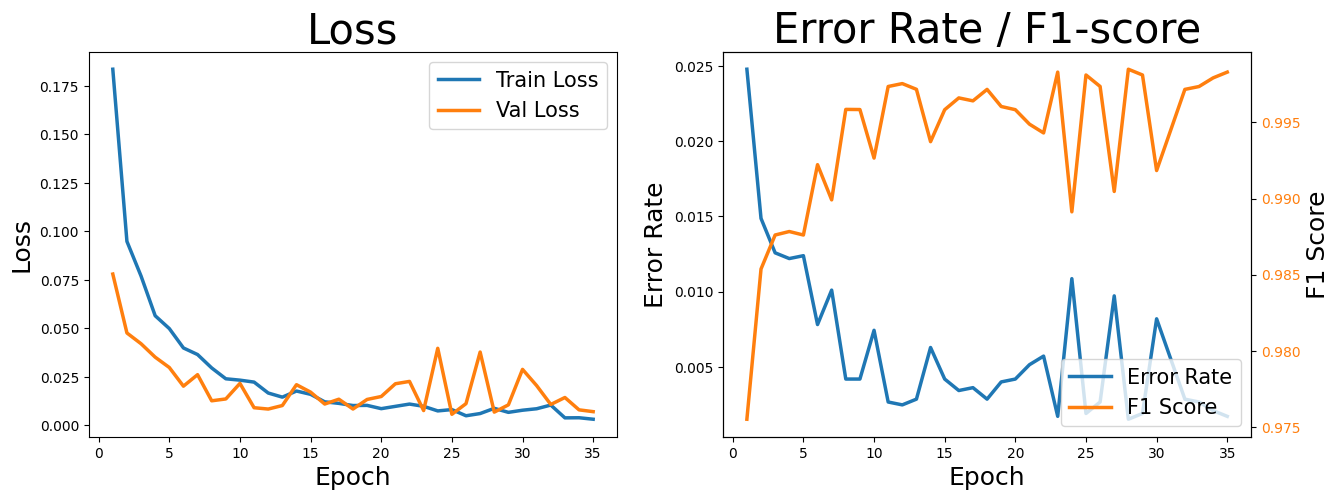

>>>>>>>>     FC Size: 6 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.4303 - Val Loss: 0.3530 - Error Rate: 0.0421 - F1 Score: 0.9596 - (FPR: 0.0704 - FNR: 0.0091)


Epoch 2/100	 Train Loss: 0.3269 - Val Loss: 0.2780 - Error Rate: 0.0164 - F1 Score: 0.9838 - (FPR: 0.0199 - FNR: 0.0128)


Epoch 3/100	 Train Loss: 0.2590 - Val Loss: 0.2282 - Error Rate: 0.0162 - F1 Score: 0.9837 - (FPR: 0.0008 - FNR: 0.0310)


Epoch 4/100	 Train Loss: 0.2097 - Val Loss: 0.1938 - Error Rate: 0.0202 - F1 Score: 0.9797 - (FPR: 0.0051 - FNR: 0.0347)


Epoch 5/100	 Train Loss: 0.1740 - Val Loss: 0.1555 - Error Rate: 0.0132 - F1 Score: 0.9868 - (FPR: 0.0015 - FNR: 0.0245)


Epoch 6/100	 Train Loss: 0.1415 - Val Loss: 0.1279 - Error Rate: 0.0095 - F1 Score: 0.9905 - (FPR: 0.0012 - FNR: 0.0178)


Epoch 7/100	 Train Loss: 0.1209 - Val Loss: 0.1128 - Error Rate: 0.0091 - F1 Score: 0.9910 - (FPR: 0.0120 - FNR: 0.0062)


Epoch 8/100	 Train Loss: 0.0978 - Val Loss: 0.0910 - Error Rate: 0.0076 - F1 Score: 0.9925 - (FPR: 0.0101 - FNR: 0.0050)


Epoch 9/100	 Train Loss: 0.0909 - Val Loss: 0.0785 - Error Rate: 0.0061 - F1 Score: 0.9940 - (FPR: 0.0075 - FNR: 0.0046)


Epoch 10/100	 Train Loss: 0.0813 - Val Loss: 0.0634 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0015 - FNR: 0.0058)


Epoch 11/100	 Train Loss: 0.0621 - Val Loss: 0.0762 - Error Rate: 0.0147 - F1 Score: 0.9853 - (FPR: 0.0000 - FNR: 0.0288)


Epoch 12/100	 Train Loss: 0.0568 - Val Loss: 0.0469 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0026 - FNR: 0.0031)


Epoch 13/100	 Train Loss: 0.0502 - Val Loss: 0.0429 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0023 - FNR: 0.0069)


Epoch 14/100	 Train Loss: 0.0443 - Val Loss: 0.0660 - Error Rate: 0.0158 - F1 Score: 0.9841 - (FPR: 0.0004 - FNR: 0.0306)


Epoch 15/100	 Train Loss: 0.0395 - Val Loss: 0.0319 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0019 - FNR: 0.0031)


Epoch 16/100	 Train Loss: 0.0381 - Val Loss: 0.0388 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0015 - FNR: 0.0122)


Epoch 17/100	 Train Loss: 0.0319 - Val Loss: 0.0276 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0000 - FNR: 0.0073)


Epoch 18/100	 Train Loss: 0.0299 - Val Loss: 0.0290 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0004 - FNR: 0.0092)


Epoch 19/100	 Train Loss: 0.0246 - Val Loss: 0.0189 - Error Rate: 0.0015 - F1 Score: 0.9985 - (FPR: 0.0004 - FNR: 0.0027)


Epoch 20/100	 Train Loss: 0.0328 - Val Loss: 0.1059 - Error Rate: 0.0316 - F1 Score: 0.9677 - (FPR: 0.0000 - FNR: 0.0601)


Epoch 21/100	 Train Loss: 0.0273 - Val Loss: 0.0193 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0023 - FNR: 0.0035)


Epoch 22/100	 Train Loss: 0.0169 - Val Loss: 0.0156 - Error Rate: 0.0015 - F1 Score: 0.9985 - (FPR: 0.0011 - FNR: 0.0019)


Epoch 23/100	 Train Loss: 0.0175 - Val Loss: 0.0187 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0049 - FNR: 0.0008)


Epoch 24/100	 Train Loss: 0.0232 - Val Loss: 0.0196 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0004 - FNR: 0.0088)


Epoch 25/100	 Train Loss: 0.0180 - Val Loss: 0.0230 - Error Rate: 0.0057 - F1 Score: 0.9943 - (FPR: 0.0000 - FNR: 0.0114)


Epoch 26/100	 Train Loss: 0.0186 - Val Loss: 0.0131 - Error Rate: 0.0019 - F1 Score: 0.9981 - (FPR: 0.0011 - FNR: 0.0027)


Epoch 27/100	 Train Loss: 0.0143 - Val Loss: 0.0150 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0004 - FNR: 0.0050)


Epoch 28/100	 Train Loss: 0.0183 - Val Loss: 0.0190 - Error Rate: 0.0046 - F1 Score: 0.9954 - (FPR: 0.0000 - FNR: 0.0092)


Epoch 29/100	 Train Loss: 0.0214 - Val Loss: 0.0103 - Error Rate: 0.0015 - F1 Score: 0.9985 - (FPR: 0.0011 - FNR: 0.0019)


Epoch 30/100	 Train Loss: 0.0172 - Val Loss: 0.0168 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0004 - FNR: 0.0069)


Epoch 31/100	 Train Loss: 0.0178 - Val Loss: 0.0152 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0000 - FNR: 0.0065)


Epoch 32/100	 Train Loss: 0.0165 - Val Loss: 0.0099 - Error Rate: 0.0017 - F1 Score: 0.9983 - (FPR: 0.0011 - FNR: 0.0023)


Epoch 33/100	 Train Loss: 0.0186 - Val Loss: 0.0155 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0004 - FNR: 0.0069)


Epoch 34/100	 Train Loss: 0.0108 - Val Loss: 0.0083 - Error Rate: 0.0011 - F1 Score: 0.9989 - (FPR: 0.0008 - FNR: 0.0015)


Epoch 35/100	 Train Loss: 0.0113 - Val Loss: 0.0122 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0008 - FNR: 0.0046)


Epoch 36/100	 Train Loss: 0.0144 - Val Loss: 0.0077 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0023 - FNR: 0.0019)


Epoch 37/100	 Train Loss: 0.0209 - Val Loss: 0.0235 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0079 - FNR: 0.0016)


Epoch 38/100	 Train Loss: 0.0130 - Val Loss: 0.0144 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0000 - FNR: 0.0057)


Epoch 39/100	 Train Loss: 0.0128 - Val Loss: 0.0347 - Error Rate: 0.0078 - F1 Score: 0.9922 - (FPR: 0.0004 - FNR: 0.0152)


Epoch 40/100	 Train Loss: 0.0213 - Val Loss: 0.0080 - Error Rate: 0.0015 - F1 Score: 0.9985 - (FPR: 0.0011 - FNR: 0.0019)


Epoch 41/100	 Train Loss: 0.0095 - Val Loss: 0.0119 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0000 - FNR: 0.0050)


Epoch 42/100	 Train Loss: 0.0156 - Val Loss: 0.0277 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0034 - FNR: 0.0077)


Epoch 43/100	 Train Loss: 0.0134 - Val Loss: 0.0073 - Error Rate: 0.0015 - F1 Score: 0.9985 - (FPR: 0.0008 - FNR: 0.0023)


Epoch 44/100	 Train Loss: 0.0106 - Val Loss: 0.0095 - Error Rate: 0.0017 - F1 Score: 0.9983 - (FPR: 0.0011 - FNR: 0.0023)


Epoch 45/100	 Train Loss: 0.0096 - Val Loss: 0.0065 - Error Rate: 0.0010 - F1 Score: 0.9991 - (FPR: 0.0000 - FNR: 0.0019)


Epoch 46/100	 Train Loss: 0.0124 - Val Loss: 0.0127 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0004 - FNR: 0.0057)


Epoch 47/100	 Train Loss: 0.0105 - Val Loss: 0.0344 - Error Rate: 0.0076 - F1 Score: 0.9924 - (FPR: 0.0000 - FNR: 0.0152)


Epoch 48/100	 Train Loss: 0.0174 - Val Loss: 0.0100 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0034 - FNR: 0.0015)


Epoch 49/100	 Train Loss: 0.0131 - Val Loss: 0.0123 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0015 - FNR: 0.0050)


Epoch 50/100	 Train Loss: 0.0117 - Val Loss: 0.0207 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0011 - FNR: 0.0088)


Epoch 51/100	 Train Loss: 0.0134 - Val Loss: 0.0149 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0000 - FNR: 0.0069)


Epoch 52/100	 Train Loss: 0.0128 - Val Loss: 0.0063 - Error Rate: 0.0011 - F1 Score: 0.9989 - (FPR: 0.0011 - FNR: 0.0012)


Epoch 53/100	 Train Loss: 0.0203 - Val Loss: 0.0217 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0000 - FNR: 0.0103)


Epoch 54/100	 Train Loss: 0.0121 - Val Loss: 0.0121 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0008 - FNR: 0.0042)


Epoch 55/100	 Train Loss: 0.0115 - Val Loss: 0.0216 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0045 - FNR: 0.0019)


Epoch 56/100	 Train Loss: 0.0120 - Val Loss: 0.0129 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0015 - FNR: 0.0061)


Epoch 57/100	 Train Loss: 0.0101 - Val Loss: 0.0108 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0000 - FNR: 0.0050)


Epoch 58/100	 Train Loss: 0.0143 - Val Loss: 0.0156 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0000 - FNR: 0.0076)


Epoch 59/100	 Train Loss: 0.0107 - Val Loss: 0.0398 - Error Rate: 0.0088 - F1 Score: 0.9912 - (FPR: 0.0004 - FNR: 0.0170)


Epoch 60/100	 Train Loss: 0.0170 - Val Loss: 0.0077 - Error Rate: 0.0019 - F1 Score: 0.9981 - (FPR: 0.0008 - FNR: 0.0031)


Epoch 61/100	 Train Loss: 0.0136 - Val Loss: 0.0353 - Error Rate: 0.0084 - F1 Score: 0.9916 - (FPR: 0.0000 - FNR: 0.0167)


Epoch 62/100	 Train Loss: 0.0103 - Val Loss: 0.0119 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0004 - FNR: 0.0057)
Early stopping on epoch 62


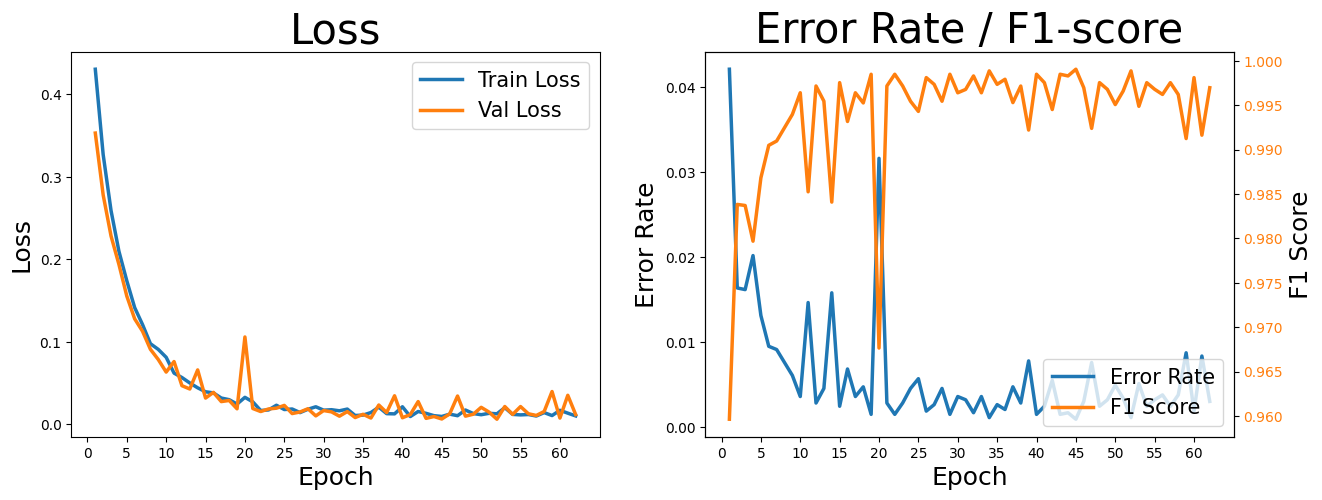

>>>>>>>>     FC Size: 6 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.5039 - Val Loss: 0.1317 - Error Rate: 0.0326 - F1 Score: 0.9682 - (FPR: 0.0452 - FNR: 0.0190)


Epoch 2/100	 Train Loss: 0.3088 - Val Loss: 0.0605 - Error Rate: 0.0172 - F1 Score: 0.9830 - (FPR: 0.0148 - FNR: 0.0195)


Epoch 3/100	 Train Loss: 0.2554 - Val Loss: 0.0481 - Error Rate: 0.0143 - F1 Score: 0.9859 - (FPR: 0.0212 - FNR: 0.0070)


Epoch 4/100	 Train Loss: 0.2195 - Val Loss: 0.0293 - Error Rate: 0.0082 - F1 Score: 0.9919 - (FPR: 0.0105 - FNR: 0.0058)


Epoch 5/100	 Train Loss: 0.2001 - Val Loss: 0.0268 - Error Rate: 0.0084 - F1 Score: 0.9917 - (FPR: 0.0113 - FNR: 0.0054)


Epoch 6/100	 Train Loss: 0.1946 - Val Loss: 0.0358 - Error Rate: 0.0097 - F1 Score: 0.9904 - (FPR: 0.0131 - FNR: 0.0062)


Epoch 7/100	 Train Loss: 0.1810 - Val Loss: 0.0346 - Error Rate: 0.0111 - F1 Score: 0.9890 - (FPR: 0.0019 - FNR: 0.0200)


Epoch 8/100	 Train Loss: 0.1826 - Val Loss: 0.0183 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0057 - FNR: 0.0046)


Epoch 9/100	 Train Loss: 0.1721 - Val Loss: 0.0180 - Error Rate: 0.0065 - F1 Score: 0.9936 - (FPR: 0.0075 - FNR: 0.0054)


Epoch 10/100	 Train Loss: 0.1488 - Val Loss: 0.0209 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0042 - FNR: 0.0096)


Epoch 11/100	 Train Loss: 0.1345 - Val Loss: 0.0278 - Error Rate: 0.0074 - F1 Score: 0.9926 - (FPR: 0.0008 - FNR: 0.0141)


Epoch 12/100	 Train Loss: 0.1290 - Val Loss: 0.0129 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0027 - FNR: 0.0065)


Epoch 13/100	 Train Loss: 0.1329 - Val Loss: 0.0196 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0008 - FNR: 0.0099)


Epoch 14/100	 Train Loss: 0.1356 - Val Loss: 0.0195 - Error Rate: 0.0059 - F1 Score: 0.9941 - (FPR: 0.0011 - FNR: 0.0107)


Epoch 15/100	 Train Loss: 0.1250 - Val Loss: 0.0150 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0008 - FNR: 0.0084)


Epoch 16/100	 Train Loss: 0.1202 - Val Loss: 0.0151 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0045 - FNR: 0.0065)


Epoch 17/100	 Train Loss: 0.1301 - Val Loss: 0.0261 - Error Rate: 0.0061 - F1 Score: 0.9939 - (FPR: 0.0008 - FNR: 0.0114)


Epoch 18/100	 Train Loss: 0.1276 - Val Loss: 0.0228 - Error Rate: 0.0063 - F1 Score: 0.9937 - (FPR: 0.0000 - FNR: 0.0125)


Epoch 19/100	 Train Loss: 0.1251 - Val Loss: 0.0127 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0026 - FNR: 0.0046)


Epoch 20/100	 Train Loss: 0.1242 - Val Loss: 0.0104 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0008 - FNR: 0.0054)


Epoch 21/100	 Train Loss: 0.1292 - Val Loss: 0.0324 - Error Rate: 0.0074 - F1 Score: 0.9926 - (FPR: 0.0023 - FNR: 0.0126)


Epoch 22/100	 Train Loss: 0.1246 - Val Loss: 0.0309 - Error Rate: 0.0082 - F1 Score: 0.9918 - (FPR: 0.0023 - FNR: 0.0141)


Epoch 23/100	 Train Loss: 0.1233 - Val Loss: 0.0067 - Error Rate: 0.0017 - F1 Score: 0.9983 - (FPR: 0.0011 - FNR: 0.0023)


Epoch 24/100	 Train Loss: 0.1207 - Val Loss: 0.0218 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0000 - FNR: 0.0099)


Epoch 25/100	 Train Loss: 0.1185 - Val Loss: 0.0139 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0004 - FNR: 0.0076)


Epoch 26/100	 Train Loss: 0.1232 - Val Loss: 0.0202 - Error Rate: 0.0057 - F1 Score: 0.9943 - (FPR: 0.0027 - FNR: 0.0088)


Epoch 27/100	 Train Loss: 0.1231 - Val Loss: 0.0099 - Error Rate: 0.0019 - F1 Score: 0.9981 - (FPR: 0.0000 - FNR: 0.0038)


Epoch 28/100	 Train Loss: 0.1228 - Val Loss: 0.0268 - Error Rate: 0.0082 - F1 Score: 0.9919 - (FPR: 0.0153 - FNR: 0.0008)


Epoch 29/100	 Train Loss: 0.1290 - Val Loss: 0.0131 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0023 - FNR: 0.0054)


Epoch 30/100	 Train Loss: 0.1257 - Val Loss: 0.0071 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0038 - FNR: 0.0015)


Epoch 31/100	 Train Loss: 0.1175 - Val Loss: 0.0209 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0000 - FNR: 0.0080)


Epoch 32/100	 Train Loss: 0.1286 - Val Loss: 0.0175 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0011 - FNR: 0.0050)


Epoch 33/100	 Train Loss: 0.1265 - Val Loss: 0.0162 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0004 - FNR: 0.0069)


Epoch 34/100	 Train Loss: 0.1230 - Val Loss: 0.0310 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0008 - FNR: 0.0092)
Early stopping on epoch 34


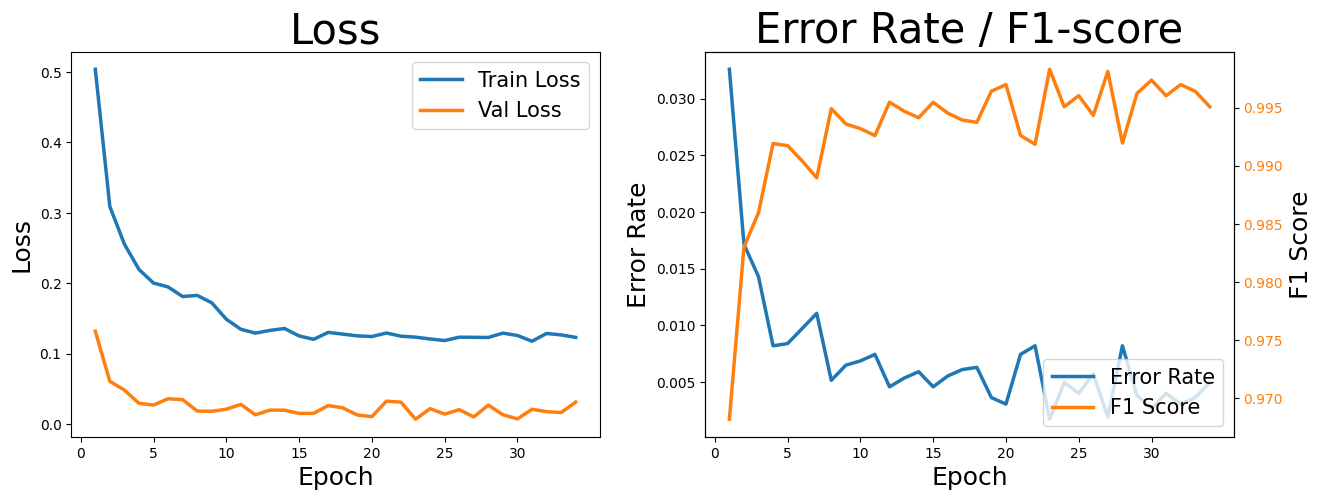

>>>>>>>>     FC Size: 12 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1637 - Val Loss: 0.0625 - Error Rate: 0.0238 - F1 Score: 0.9761 - (FPR: 0.0093 - FNR: 0.0378)


Epoch 2/100	 Train Loss: 0.0728 - Val Loss: 0.0760 - Error Rate: 0.0286 - F1 Score: 0.9719 - (FPR: 0.0339 - FNR: 0.0230)


Epoch 3/100	 Train Loss: 0.0510 - Val Loss: 0.0336 - Error Rate: 0.0101 - F1 Score: 0.9901 - (FPR: 0.0160 - FNR: 0.0039)


Epoch 4/100	 Train Loss: 0.0407 - Val Loss: 0.0240 - Error Rate: 0.0072 - F1 Score: 0.9928 - (FPR: 0.0090 - FNR: 0.0054)


Epoch 5/100	 Train Loss: 0.0294 - Val Loss: 0.0194 - Error Rate: 0.0065 - F1 Score: 0.9936 - (FPR: 0.0034 - FNR: 0.0096)


Epoch 6/100	 Train Loss: 0.0237 - Val Loss: 0.0408 - Error Rate: 0.0139 - F1 Score: 0.9860 - (FPR: 0.0004 - FNR: 0.0270)


Epoch 7/100	 Train Loss: 0.0190 - Val Loss: 0.0263 - Error Rate: 0.0103 - F1 Score: 0.9897 - (FPR: 0.0004 - FNR: 0.0200)


Epoch 8/100	 Train Loss: 0.0156 - Val Loss: 0.0161 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0049 - FNR: 0.0054)


Epoch 9/100	 Train Loss: 0.0131 - Val Loss: 0.0222 - Error Rate: 0.0067 - F1 Score: 0.9934 - (FPR: 0.0011 - FNR: 0.0122)


Epoch 10/100	 Train Loss: 0.0097 - Val Loss: 0.0133 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0019 - FNR: 0.0084)


Epoch 11/100	 Train Loss: 0.0096 - Val Loss: 0.0385 - Error Rate: 0.0086 - F1 Score: 0.9914 - (FPR: 0.0015 - FNR: 0.0156)


Epoch 12/100	 Train Loss: 0.0089 - Val Loss: 0.0237 - Error Rate: 0.0078 - F1 Score: 0.9922 - (FPR: 0.0015 - FNR: 0.0141)


Epoch 13/100	 Train Loss: 0.0057 - Val Loss: 0.0119 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0053 - FNR: 0.0019)


Epoch 14/100	 Train Loss: 0.0070 - Val Loss: 0.0186 - Error Rate: 0.0063 - F1 Score: 0.9937 - (FPR: 0.0015 - FNR: 0.0111)


Epoch 15/100	 Train Loss: 0.0047 - Val Loss: 0.0214 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0023 - FNR: 0.0088)


Epoch 16/100	 Train Loss: 0.0079 - Val Loss: 0.0299 - Error Rate: 0.0067 - F1 Score: 0.9933 - (FPR: 0.0000 - FNR: 0.0133)


Epoch 17/100	 Train Loss: 0.0039 - Val Loss: 0.0128 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0060 - FNR: 0.0012)


Epoch 18/100	 Train Loss: 0.0034 - Val Loss: 0.0362 - Error Rate: 0.0071 - F1 Score: 0.9930 - (FPR: 0.0004 - FNR: 0.0137)


Epoch 19/100	 Train Loss: 0.0076 - Val Loss: 0.0181 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0027 - FNR: 0.0080)


Epoch 20/100	 Train Loss: 0.0075 - Val Loss: 0.0101 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0015 - FNR: 0.0035)


Epoch 21/100	 Train Loss: 0.0053 - Val Loss: 0.0097 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0038 - FNR: 0.0015)


Epoch 22/100	 Train Loss: 0.0047 - Val Loss: 0.0172 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0008 - FNR: 0.0088)


Epoch 23/100	 Train Loss: 0.0046 - Val Loss: 0.0127 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0030 - FNR: 0.0046)


Epoch 24/100	 Train Loss: 0.0026 - Val Loss: 0.0136 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0019 - FNR: 0.0065)


Epoch 25/100	 Train Loss: 0.0064 - Val Loss: 0.0119 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0008 - FNR: 0.0054)


Epoch 26/100	 Train Loss: 0.0031 - Val Loss: 0.0097 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0053 - FNR: 0.0012)


Epoch 27/100	 Train Loss: 0.0021 - Val Loss: 0.0138 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0015 - FNR: 0.0054)


Epoch 28/100	 Train Loss: 0.0015 - Val Loss: 0.0296 - Error Rate: 0.0057 - F1 Score: 0.9943 - (FPR: 0.0000 - FNR: 0.0114)


Epoch 29/100	 Train Loss: 0.0074 - Val Loss: 0.0097 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0004 - FNR: 0.0054)


Epoch 30/100	 Train Loss: 0.0038 - Val Loss: 0.0249 - Error Rate: 0.0084 - F1 Score: 0.9916 - (FPR: 0.0000 - FNR: 0.0167)


Epoch 31/100	 Train Loss: 0.0028 - Val Loss: 0.0119 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0004 - FNR: 0.0046)


Epoch 32/100	 Train Loss: 0.0031 - Val Loss: 0.0588 - Error Rate: 0.0133 - F1 Score: 0.9866 - (FPR: 0.0000 - FNR: 0.0262)


Epoch 33/100	 Train Loss: 0.0063 - Val Loss: 0.0144 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0008 - FNR: 0.0065)


Epoch 34/100	 Train Loss: 0.0053 - Val Loss: 0.0141 - Error Rate: 0.0063 - F1 Score: 0.9938 - (FPR: 0.0094 - FNR: 0.0031)


Epoch 35/100	 Train Loss: 0.0022 - Val Loss: 0.0184 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0000 - FNR: 0.0069)


Epoch 36/100	 Train Loss: 0.0028 - Val Loss: 0.0105 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0015 - FNR: 0.0046)


Epoch 37/100	 Train Loss: 0.0026 - Val Loss: 0.0170 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0008 - FNR: 0.0069)


Epoch 38/100	 Train Loss: 0.0018 - Val Loss: 0.0117 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0000 - FNR: 0.0054)


Epoch 39/100	 Train Loss: 0.0024 - Val Loss: 0.0110 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0008 - FNR: 0.0046)
Early stopping on epoch 39


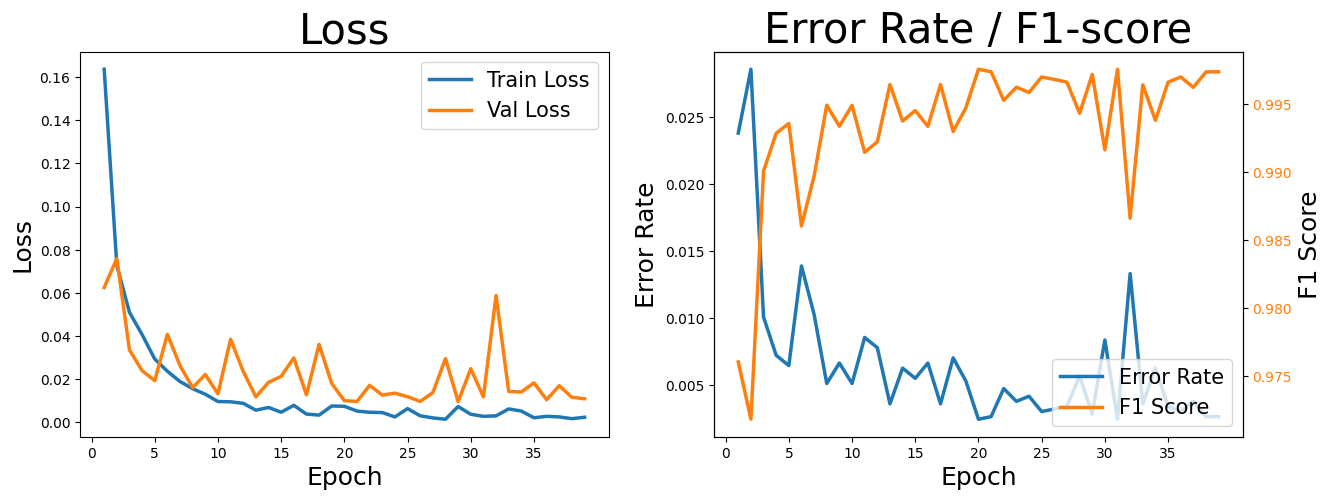

>>>>>>>>     FC Size: 12 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1982 - Val Loss: 0.0729 - Error Rate: 0.0284 - F1 Score: 0.9715 - (FPR: 0.0144 - FNR: 0.0419)


Epoch 2/100	 Train Loss: 0.1129 - Val Loss: 0.0716 - Error Rate: 0.0221 - F1 Score: 0.9782 - (FPR: 0.0258 - FNR: 0.0183)


Epoch 3/100	 Train Loss: 0.1011 - Val Loss: 0.0424 - Error Rate: 0.0172 - F1 Score: 0.9828 - (FPR: 0.0054 - FNR: 0.0286)


Epoch 4/100	 Train Loss: 0.0868 - Val Loss: 0.0357 - Error Rate: 0.0097 - F1 Score: 0.9903 - (FPR: 0.0068 - FNR: 0.0126)


Epoch 5/100	 Train Loss: 0.0701 - Val Loss: 0.0296 - Error Rate: 0.0090 - F1 Score: 0.9911 - (FPR: 0.0109 - FNR: 0.0070)


Epoch 6/100	 Train Loss: 0.0559 - Val Loss: 0.0257 - Error Rate: 0.0078 - F1 Score: 0.9923 - (FPR: 0.0076 - FNR: 0.0081)


Epoch 7/100	 Train Loss: 0.0529 - Val Loss: 0.0260 - Error Rate: 0.0082 - F1 Score: 0.9918 - (FPR: 0.0011 - FNR: 0.0152)


Epoch 8/100	 Train Loss: 0.0387 - Val Loss: 0.0121 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0038 - FNR: 0.0031)


Epoch 9/100	 Train Loss: 0.0274 - Val Loss: 0.0246 - Error Rate: 0.0084 - F1 Score: 0.9917 - (FPR: 0.0116 - FNR: 0.0050)


Epoch 10/100	 Train Loss: 0.0280 - Val Loss: 0.0145 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0019 - FNR: 0.0077)


Epoch 11/100	 Train Loss: 0.0208 - Val Loss: 0.0162 - Error Rate: 0.0072 - F1 Score: 0.9928 - (FPR: 0.0072 - FNR: 0.0073)


Epoch 12/100	 Train Loss: 0.0158 - Val Loss: 0.0226 - Error Rate: 0.0065 - F1 Score: 0.9935 - (FPR: 0.0004 - FNR: 0.0126)


Epoch 13/100	 Train Loss: 0.0132 - Val Loss: 0.0156 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0064 - FNR: 0.0042)


Epoch 14/100	 Train Loss: 0.0146 - Val Loss: 0.0303 - Error Rate: 0.0076 - F1 Score: 0.9924 - (FPR: 0.0000 - FNR: 0.0152)


Epoch 15/100	 Train Loss: 0.0131 - Val Loss: 0.0277 - Error Rate: 0.0091 - F1 Score: 0.9910 - (FPR: 0.0156 - FNR: 0.0023)


Epoch 16/100	 Train Loss: 0.0121 - Val Loss: 0.0206 - Error Rate: 0.0059 - F1 Score: 0.9941 - (FPR: 0.0053 - FNR: 0.0065)


Epoch 17/100	 Train Loss: 0.0109 - Val Loss: 0.0203 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0015 - FNR: 0.0088)


Epoch 18/100	 Train Loss: 0.0103 - Val Loss: 0.0150 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0008 - FNR: 0.0076)
Early stopping on epoch 18


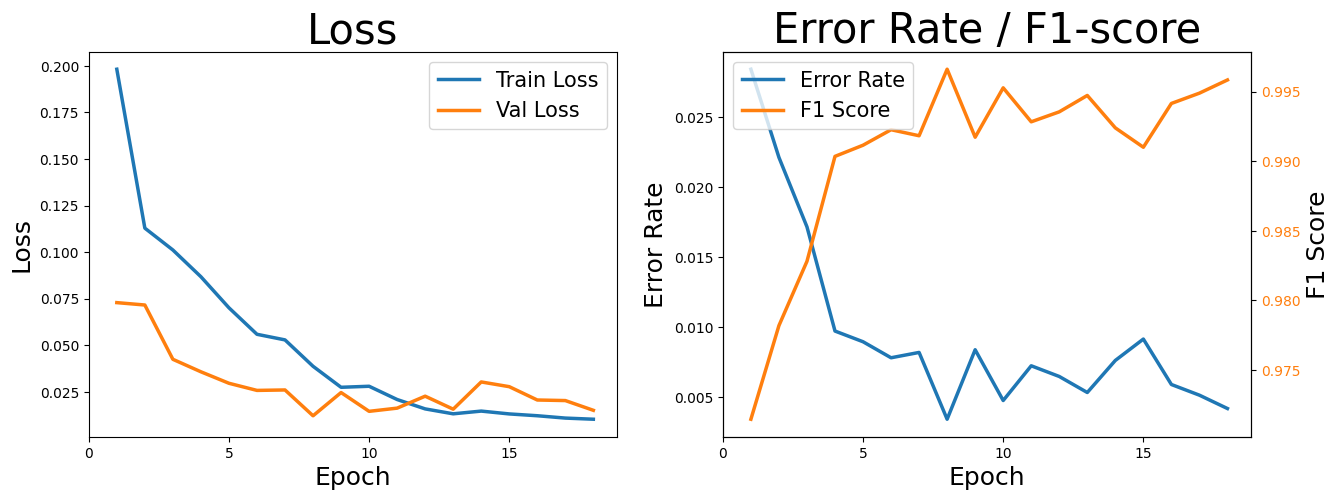

>>>>>>>>     FC Size: 12 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2485 - Val Loss: 0.0856 - Error Rate: 0.0328 - F1 Score: 0.9668 - (FPR: 0.0114 - FNR: 0.0527)


Epoch 2/100	 Train Loss: 0.1659 - Val Loss: 0.0746 - Error Rate: 0.0343 - F1 Score: 0.9651 - (FPR: 0.0072 - FNR: 0.0591)


Epoch 3/100	 Train Loss: 0.1366 - Val Loss: 0.0732 - Error Rate: 0.0242 - F1 Score: 0.9756 - (FPR: 0.0067 - FNR: 0.0409)


Epoch 4/100	 Train Loss: 0.1142 - Val Loss: 0.0528 - Error Rate: 0.0246 - F1 Score: 0.9751 - (FPR: 0.0008 - FNR: 0.0467)


Epoch 5/100	 Train Loss: 0.1021 - Val Loss: 0.0282 - Error Rate: 0.0112 - F1 Score: 0.9889 - (FPR: 0.0175 - FNR: 0.0047)


Epoch 6/100	 Train Loss: 0.0967 - Val Loss: 0.0273 - Error Rate: 0.0101 - F1 Score: 0.9900 - (FPR: 0.0135 - FNR: 0.0066)


Epoch 7/100	 Train Loss: 0.0783 - Val Loss: 0.0234 - Error Rate: 0.0086 - F1 Score: 0.9915 - (FPR: 0.0105 - FNR: 0.0066)


Epoch 8/100	 Train Loss: 0.0691 - Val Loss: 0.0443 - Error Rate: 0.0202 - F1 Score: 0.9804 - (FPR: 0.0375 - FNR: 0.0012)


Epoch 9/100	 Train Loss: 0.0617 - Val Loss: 0.0211 - Error Rate: 0.0082 - F1 Score: 0.9919 - (FPR: 0.0138 - FNR: 0.0023)


Epoch 10/100	 Train Loss: 0.0588 - Val Loss: 0.0227 - Error Rate: 0.0074 - F1 Score: 0.9926 - (FPR: 0.0008 - FNR: 0.0141)


Epoch 11/100	 Train Loss: 0.0568 - Val Loss: 0.0164 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0023 - FNR: 0.0069)


Epoch 12/100	 Train Loss: 0.0517 - Val Loss: 0.0173 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0038 - FNR: 0.0073)


Epoch 13/100	 Train Loss: 0.0425 - Val Loss: 0.0196 - Error Rate: 0.0059 - F1 Score: 0.9942 - (FPR: 0.0079 - FNR: 0.0039)


Epoch 14/100	 Train Loss: 0.0385 - Val Loss: 0.0104 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0019 - FNR: 0.0046)


Epoch 15/100	 Train Loss: 0.0438 - Val Loss: 0.0333 - Error Rate: 0.0076 - F1 Score: 0.9924 - (FPR: 0.0064 - FNR: 0.0088)


Epoch 16/100	 Train Loss: 0.0383 - Val Loss: 0.0336 - Error Rate: 0.0071 - F1 Score: 0.9930 - (FPR: 0.0000 - FNR: 0.0140)


Epoch 17/100	 Train Loss: 0.0409 - Val Loss: 0.0148 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0023 - FNR: 0.0080)


Epoch 18/100	 Train Loss: 0.0343 - Val Loss: 0.0100 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0008 - FNR: 0.0054)


Epoch 19/100	 Train Loss: 0.0329 - Val Loss: 0.0129 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0008 - FNR: 0.0050)


Epoch 20/100	 Train Loss: 0.0378 - Val Loss: 0.0110 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0015 - FNR: 0.0069)


Epoch 21/100	 Train Loss: 0.0349 - Val Loss: 0.0156 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0008 - FNR: 0.0065)


Epoch 22/100	 Train Loss: 0.0412 - Val Loss: 0.0334 - Error Rate: 0.0191 - F1 Score: 0.9808 - (FPR: 0.0000 - FNR: 0.0371)


Epoch 23/100	 Train Loss: 0.0361 - Val Loss: 0.0126 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0004 - FNR: 0.0069)


Epoch 24/100	 Train Loss: 0.0351 - Val Loss: 0.0673 - Error Rate: 0.0103 - F1 Score: 0.9897 - (FPR: 0.0000 - FNR: 0.0204)


Epoch 25/100	 Train Loss: 0.0353 - Val Loss: 0.0151 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0008 - FNR: 0.0054)


Epoch 26/100	 Train Loss: 0.0327 - Val Loss: 0.0094 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0019 - FNR: 0.0042)


Epoch 27/100	 Train Loss: 0.0365 - Val Loss: 0.0189 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0004 - FNR: 0.0095)


Epoch 28/100	 Train Loss: 0.0343 - Val Loss: 0.0125 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0030 - FNR: 0.0050)


Epoch 29/100	 Train Loss: 0.0357 - Val Loss: 0.0084 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0000 - FNR: 0.0054)


Epoch 30/100	 Train Loss: 0.0333 - Val Loss: 0.0428 - Error Rate: 0.0093 - F1 Score: 0.9907 - (FPR: 0.0000 - FNR: 0.0185)


Epoch 31/100	 Train Loss: 0.0319 - Val Loss: 0.0122 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0000 - FNR: 0.0073)


Epoch 32/100	 Train Loss: 0.0353 - Val Loss: 0.0237 - Error Rate: 0.0120 - F1 Score: 0.9880 - (FPR: 0.0004 - FNR: 0.0233)


Epoch 33/100	 Train Loss: 0.0364 - Val Loss: 0.0189 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0015 - FNR: 0.0065)


Epoch 34/100	 Train Loss: 0.0328 - Val Loss: 0.0154 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0015 - FNR: 0.0054)


Epoch 35/100	 Train Loss: 0.0367 - Val Loss: 0.0078 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0004 - FNR: 0.0046)


Epoch 36/100	 Train Loss: 0.0294 - Val Loss: 0.0106 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0004 - FNR: 0.0046)


Epoch 37/100	 Train Loss: 0.0297 - Val Loss: 0.0137 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0004 - FNR: 0.0046)


Epoch 38/100	 Train Loss: 0.0316 - Val Loss: 0.0178 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0004 - FNR: 0.0046)


Epoch 39/100	 Train Loss: 0.0276 - Val Loss: 0.0222 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0000 - FNR: 0.0050)


Epoch 40/100	 Train Loss: 0.0391 - Val Loss: 0.0914 - Error Rate: 0.0128 - F1 Score: 0.9872 - (FPR: 0.0000 - FNR: 0.0252)


Epoch 41/100	 Train Loss: 0.0398 - Val Loss: 0.0100 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0000 - FNR: 0.0080)


Epoch 42/100	 Train Loss: 0.0295 - Val Loss: 0.0242 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0004 - FNR: 0.0092)


Epoch 43/100	 Train Loss: 0.0372 - Val Loss: 0.0105 - Error Rate: 0.0023 - F1 Score: 0.9977 - (FPR: 0.0000 - FNR: 0.0046)


Epoch 44/100	 Train Loss: 0.0334 - Val Loss: 0.0081 - Error Rate: 0.0023 - F1 Score: 0.9977 - (FPR: 0.0019 - FNR: 0.0027)


Epoch 45/100	 Train Loss: 0.0309 - Val Loss: 0.0107 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0004 - FNR: 0.0073)


Epoch 46/100	 Train Loss: 0.0322 - Val Loss: 0.0100 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0000 - FNR: 0.0042)
Early stopping on epoch 46


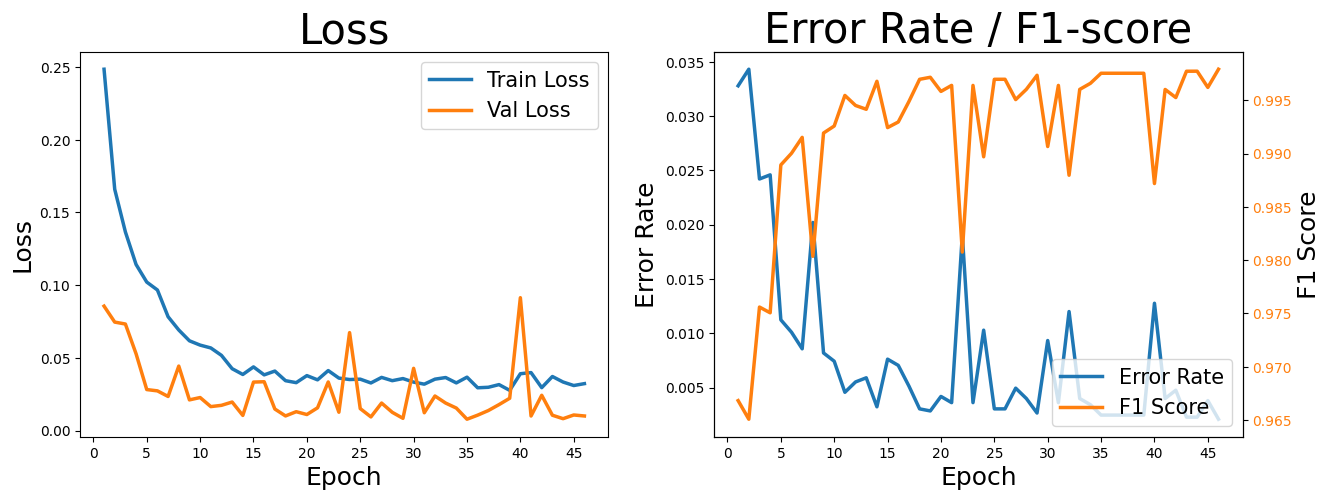

>>>>>>>>     FC Size: 24 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1637 - Val Loss: 0.0851 - Error Rate: 0.0299 - F1 Score: 0.9708 - (FPR: 0.0439 - FNR: 0.0147)


Epoch 2/100	 Train Loss: 0.0802 - Val Loss: 0.0444 - Error Rate: 0.0179 - F1 Score: 0.9822 - (FPR: 0.0133 - FNR: 0.0225)


Epoch 3/100	 Train Loss: 0.0511 - Val Loss: 0.0358 - Error Rate: 0.0130 - F1 Score: 0.9871 - (FPR: 0.0065 - FNR: 0.0194)


Epoch 4/100	 Train Loss: 0.0376 - Val Loss: 0.0293 - Error Rate: 0.0109 - F1 Score: 0.9892 - (FPR: 0.0050 - FNR: 0.0167)


Epoch 5/100	 Train Loss: 0.0271 - Val Loss: 0.0256 - Error Rate: 0.0099 - F1 Score: 0.9901 - (FPR: 0.0015 - FNR: 0.0182)


Epoch 6/100	 Train Loss: 0.0221 - Val Loss: 0.0172 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0057 - FNR: 0.0042)


Epoch 7/100	 Train Loss: 0.0134 - Val Loss: 0.0223 - Error Rate: 0.0074 - F1 Score: 0.9926 - (FPR: 0.0079 - FNR: 0.0069)


Epoch 8/100	 Train Loss: 0.0143 - Val Loss: 0.0150 - Error Rate: 0.0059 - F1 Score: 0.9941 - (FPR: 0.0027 - FNR: 0.0092)


Epoch 9/100	 Train Loss: 0.0081 - Val Loss: 0.0103 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0060 - FNR: 0.0012)


Epoch 10/100	 Train Loss: 0.0073 - Val Loss: 0.0126 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0068 - FNR: 0.0035)


Epoch 11/100	 Train Loss: 0.0110 - Val Loss: 0.0149 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0086 - FNR: 0.0016)


Epoch 12/100	 Train Loss: 0.0072 - Val Loss: 0.0188 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0008 - FNR: 0.0099)


Epoch 13/100	 Train Loss: 0.0059 - Val Loss: 0.0234 - Error Rate: 0.0061 - F1 Score: 0.9939 - (FPR: 0.0004 - FNR: 0.0118)


Epoch 14/100	 Train Loss: 0.0057 - Val Loss: 0.0185 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0071 - FNR: 0.0035)


Epoch 15/100	 Train Loss: 0.0052 - Val Loss: 0.0152 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0008 - FNR: 0.0073)


Epoch 16/100	 Train Loss: 0.0074 - Val Loss: 0.0060 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0019 - FNR: 0.0023)


Epoch 17/100	 Train Loss: 0.0023 - Val Loss: 0.0048 - Error Rate: 0.0011 - F1 Score: 0.9989 - (FPR: 0.0004 - FNR: 0.0019)


Epoch 18/100	 Train Loss: 0.0049 - Val Loss: 0.0155 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0023 - FNR: 0.0054)


Epoch 19/100	 Train Loss: 0.0054 - Val Loss: 0.0111 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0000 - FNR: 0.0065)


Epoch 20/100	 Train Loss: 0.0082 - Val Loss: 0.0182 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0027 - FNR: 0.0058)


Epoch 21/100	 Train Loss: 0.0035 - Val Loss: 0.0153 - Error Rate: 0.0044 - F1 Score: 0.9957 - (FPR: 0.0042 - FNR: 0.0046)


Epoch 22/100	 Train Loss: 0.0040 - Val Loss: 0.0098 - Error Rate: 0.0044 - F1 Score: 0.9957 - (FPR: 0.0068 - FNR: 0.0019)


Epoch 23/100	 Train Loss: 0.0047 - Val Loss: 0.0105 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0034 - FNR: 0.0035)


Epoch 24/100	 Train Loss: 0.0022 - Val Loss: 0.0364 - Error Rate: 0.0071 - F1 Score: 0.9930 - (FPR: 0.0023 - FNR: 0.0118)


Epoch 25/100	 Train Loss: 0.0037 - Val Loss: 0.0040 - Error Rate: 0.0011 - F1 Score: 0.9989 - (FPR: 0.0000 - FNR: 0.0023)


Epoch 26/100	 Train Loss: 0.0001 - Val Loss: 0.0097 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0000 - FNR: 0.0050)


Epoch 27/100	 Train Loss: 0.0001 - Val Loss: 0.0200 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0000 - FNR: 0.0084)


Epoch 28/100	 Train Loss: 0.0001 - Val Loss: 0.0070 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0000 - FNR: 0.0042)


Epoch 29/100	 Train Loss: 0.0072 - Val Loss: 0.0207 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0075 - FNR: 0.0062)


Epoch 30/100	 Train Loss: 0.0082 - Val Loss: 0.0161 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0008 - FNR: 0.0073)


Epoch 31/100	 Train Loss: 0.0034 - Val Loss: 0.0115 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0026 - FNR: 0.0038)


Epoch 32/100	 Train Loss: 0.0058 - Val Loss: 0.0079 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0011 - FNR: 0.0038)


Epoch 33/100	 Train Loss: 0.0004 - Val Loss: 0.0073 - Error Rate: 0.0017 - F1 Score: 0.9983 - (FPR: 0.0000 - FNR: 0.0035)


Epoch 34/100	 Train Loss: 0.0003 - Val Loss: 0.0117 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0004 - FNR: 0.0038)


Epoch 35/100	 Train Loss: 0.0001 - Val Loss: 0.0142 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0000 - FNR: 0.0050)
Early stopping on epoch 35


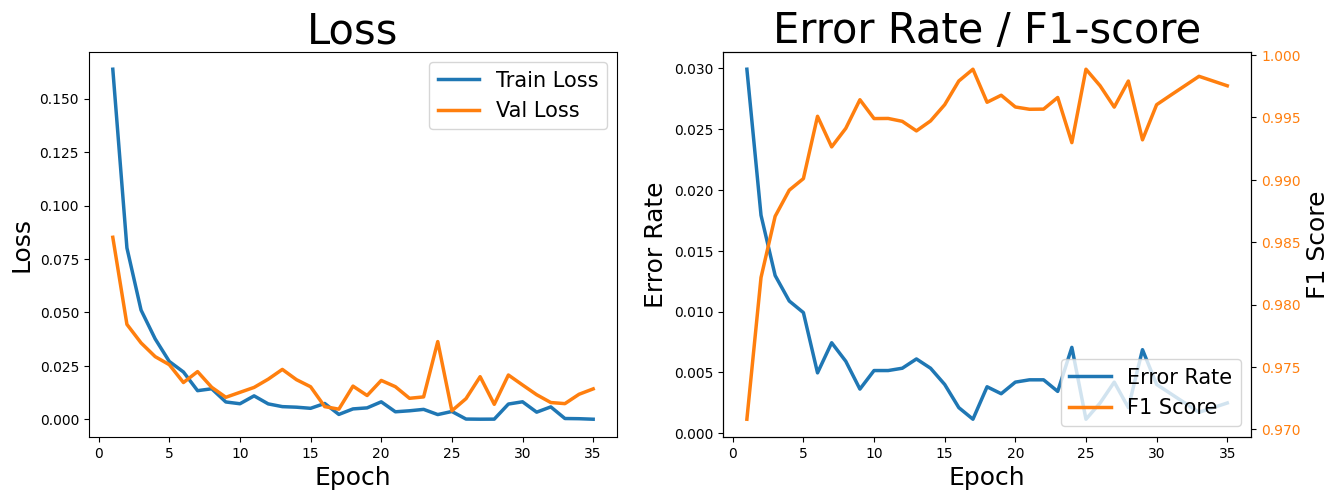

>>>>>>>>     FC Size: 24 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1924 - Val Loss: 0.0764 - Error Rate: 0.0301 - F1 Score: 0.9696 - (FPR: 0.0098 - FNR: 0.0492)


Epoch 2/100	 Train Loss: 0.0846 - Val Loss: 0.0487 - Error Rate: 0.0160 - F1 Score: 0.9841 - (FPR: 0.0125 - FNR: 0.0195)


Epoch 3/100	 Train Loss: 0.0635 - Val Loss: 0.0367 - Error Rate: 0.0124 - F1 Score: 0.9876 - (FPR: 0.0046 - FNR: 0.0201)


Epoch 4/100	 Train Loss: 0.0525 - Val Loss: 0.0249 - Error Rate: 0.0086 - F1 Score: 0.9915 - (FPR: 0.0090 - FNR: 0.0081)


Epoch 5/100	 Train Loss: 0.0378 - Val Loss: 0.0187 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0030 - FNR: 0.0107)


Epoch 6/100	 Train Loss: 0.0325 - Val Loss: 0.0305 - Error Rate: 0.0112 - F1 Score: 0.9889 - (FPR: 0.0179 - FNR: 0.0043)


Epoch 7/100	 Train Loss: 0.0260 - Val Loss: 0.0188 - Error Rate: 0.0076 - F1 Score: 0.9925 - (FPR: 0.0109 - FNR: 0.0043)


Epoch 8/100	 Train Loss: 0.0239 - Val Loss: 0.0180 - Error Rate: 0.0057 - F1 Score: 0.9943 - (FPR: 0.0015 - FNR: 0.0099)


Epoch 9/100	 Train Loss: 0.0214 - Val Loss: 0.0219 - Error Rate: 0.0074 - F1 Score: 0.9927 - (FPR: 0.0120 - FNR: 0.0027)


Epoch 10/100	 Train Loss: 0.0189 - Val Loss: 0.0139 - Error Rate: 0.0057 - F1 Score: 0.9944 - (FPR: 0.0079 - FNR: 0.0035)


Epoch 11/100	 Train Loss: 0.0168 - Val Loss: 0.0199 - Error Rate: 0.0080 - F1 Score: 0.9920 - (FPR: 0.0030 - FNR: 0.0130)


Epoch 12/100	 Train Loss: 0.0124 - Val Loss: 0.0091 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0004 - FNR: 0.0057)


Epoch 13/100	 Train Loss: 0.0118 - Val Loss: 0.0255 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0000 - FNR: 0.0137)


Epoch 14/100	 Train Loss: 0.0135 - Val Loss: 0.0122 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0030 - FNR: 0.0050)


Epoch 15/100	 Train Loss: 0.0104 - Val Loss: 0.0182 - Error Rate: 0.0061 - F1 Score: 0.9939 - (FPR: 0.0019 - FNR: 0.0103)


Epoch 16/100	 Train Loss: 0.0091 - Val Loss: 0.0214 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0027 - FNR: 0.0077)


Epoch 17/100	 Train Loss: 0.0078 - Val Loss: 0.0195 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0000 - FNR: 0.0076)


Epoch 18/100	 Train Loss: 0.0083 - Val Loss: 0.0125 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0011 - FNR: 0.0054)


Epoch 19/100	 Train Loss: 0.0102 - Val Loss: 0.0259 - Error Rate: 0.0076 - F1 Score: 0.9924 - (FPR: 0.0004 - FNR: 0.0148)


Epoch 20/100	 Train Loss: 0.0041 - Val Loss: 0.0145 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0008 - FNR: 0.0057)


Epoch 21/100	 Train Loss: 0.0021 - Val Loss: 0.0192 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0000 - FNR: 0.0065)


Epoch 22/100	 Train Loss: 0.0063 - Val Loss: 0.0338 - Error Rate: 0.0071 - F1 Score: 0.9930 - (FPR: 0.0008 - FNR: 0.0133)
Early stopping on epoch 22


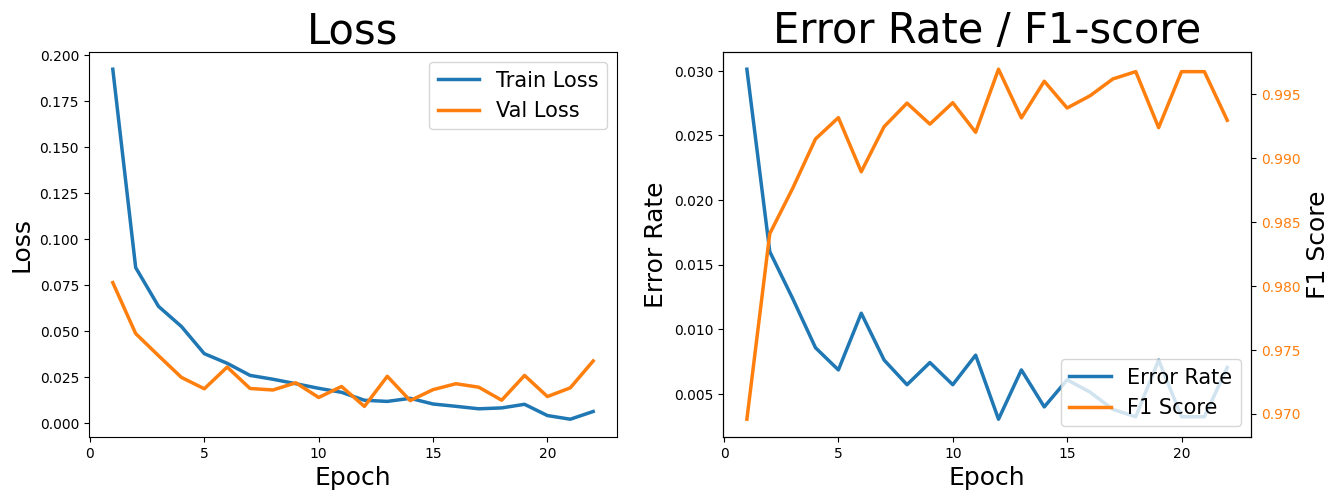

>>>>>>>>     FC Size: 24 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1917 - Val Loss: 0.0684 - Error Rate: 0.0274 - F1 Score: 0.9729 - (FPR: 0.0314 - FNR: 0.0233)


Epoch 2/100	 Train Loss: 0.0870 - Val Loss: 0.0722 - Error Rate: 0.0273 - F1 Score: 0.9727 - (FPR: 0.0170 - FNR: 0.0373)


Epoch 3/100	 Train Loss: 0.0695 - Val Loss: 0.0327 - Error Rate: 0.0126 - F1 Score: 0.9876 - (FPR: 0.0157 - FNR: 0.0093)


Epoch 4/100	 Train Loss: 0.0527 - Val Loss: 0.0302 - Error Rate: 0.0091 - F1 Score: 0.9909 - (FPR: 0.0098 - FNR: 0.0085)


Epoch 5/100	 Train Loss: 0.0452 - Val Loss: 0.0215 - Error Rate: 0.0074 - F1 Score: 0.9926 - (FPR: 0.0079 - FNR: 0.0069)


Epoch 6/100	 Train Loss: 0.0330 - Val Loss: 0.0421 - Error Rate: 0.0160 - F1 Score: 0.9839 - (FPR: 0.0004 - FNR: 0.0310)


Epoch 7/100	 Train Loss: 0.0331 - Val Loss: 0.0200 - Error Rate: 0.0059 - F1 Score: 0.9941 - (FPR: 0.0008 - FNR: 0.0111)


Epoch 8/100	 Train Loss: 0.0208 - Val Loss: 0.0449 - Error Rate: 0.0168 - F1 Score: 0.9835 - (FPR: 0.0242 - FNR: 0.0090)


Epoch 9/100	 Train Loss: 0.0246 - Val Loss: 0.0155 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0026 - FNR: 0.0050)


Epoch 10/100	 Train Loss: 0.0155 - Val Loss: 0.0157 - Error Rate: 0.0044 - F1 Score: 0.9956 - (FPR: 0.0004 - FNR: 0.0084)


Epoch 11/100	 Train Loss: 0.0131 - Val Loss: 0.0164 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0083 - FNR: 0.0027)


Epoch 12/100	 Train Loss: 0.0147 - Val Loss: 0.0155 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0004 - FNR: 0.0107)


Epoch 13/100	 Train Loss: 0.0137 - Val Loss: 0.0108 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0015 - FNR: 0.0038)


Epoch 14/100	 Train Loss: 0.0134 - Val Loss: 0.0136 - Error Rate: 0.0059 - F1 Score: 0.9941 - (FPR: 0.0030 - FNR: 0.0088)


Epoch 15/100	 Train Loss: 0.0111 - Val Loss: 0.0127 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0023 - FNR: 0.0046)


Epoch 16/100	 Train Loss: 0.0100 - Val Loss: 0.0191 - Error Rate: 0.0074 - F1 Score: 0.9927 - (FPR: 0.0123 - FNR: 0.0023)


Epoch 17/100	 Train Loss: 0.0107 - Val Loss: 0.0210 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0004 - FNR: 0.0073)


Epoch 18/100	 Train Loss: 0.0086 - Val Loss: 0.0148 - Error Rate: 0.0044 - F1 Score: 0.9957 - (FPR: 0.0027 - FNR: 0.0061)


Epoch 19/100	 Train Loss: 0.0094 - Val Loss: 0.0137 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0015 - FNR: 0.0054)


Epoch 20/100	 Train Loss: 0.0126 - Val Loss: 0.0336 - Error Rate: 0.0072 - F1 Score: 0.9928 - (FPR: 0.0000 - FNR: 0.0144)


Epoch 21/100	 Train Loss: 0.0073 - Val Loss: 0.0130 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0023 - FNR: 0.0038)


Epoch 22/100	 Train Loss: 0.0101 - Val Loss: 0.0293 - Error Rate: 0.0061 - F1 Score: 0.9939 - (FPR: 0.0000 - FNR: 0.0122)


Epoch 23/100	 Train Loss: 0.0049 - Val Loss: 0.0157 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0090 - FNR: 0.0019)
Early stopping on epoch 23


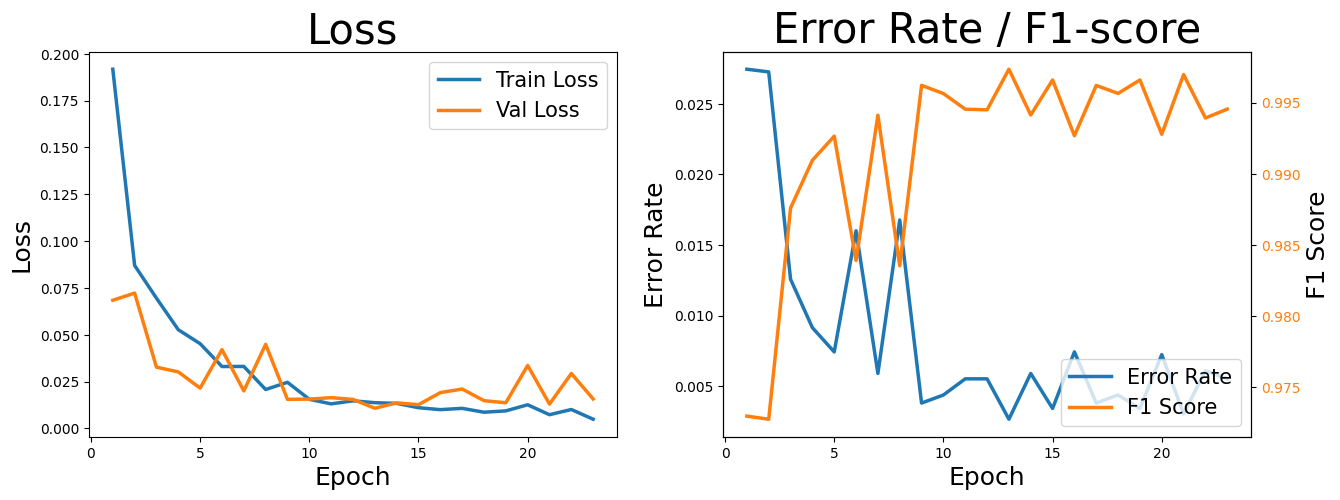

In [19]:
fc_sizes = [6, 12, 24]
dropouts = [0.1, 0.3, 0.5]
%matplotlib inline

best_models = []

for fc_size in fc_sizes:
    for dropout in dropouts:
        
        print(f'>>>>>>>>     FC Size: {fc_size} - Dropout: {dropout}     <<<<<<<<')
        # Create the model
        model = CustomConvNet(fc_size=fc_size, dropout=dropout).to(device)

        # Define the loss function and optimizer
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Create the dataloaders
        train_dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=False)

        train_losses = []
        val_losses = []
        err_rates = []
        f1_scores = []
        early_stopper = EarlyStopper(patience=10, min_delta=5e-4)
        best_epoch = None

        for epoch in range(EPOCHS):
            train_loss = train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc=f'TrainingEpoch{(epoch + 1):02d}')
            val_loss, errors, confusion_matrix = evaluate(val_dataloader, model, criterion, desc=f'ValidationEpoch{(epoch + 1):02d}')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            error_rate = (sum(errors) / len(val_data)).item()
            err_rates.append(error_rate)
            f1 = f1_score(confusion_matrix)
            f1_scores.append(f1)
            fpr = confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
            fnr = confusion_matrix[1][0] / (confusion_matrix[1][0] + confusion_matrix[1][1])
            print(f'Epoch {epoch + 1}/{EPOCHS}\t Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Error Rate: {error_rate:.4f} - F1 Score: {f1:.4f} - (FPR: {fpr:.4f} - FNR: {fnr:.4f})')
            if best_epoch is None or val_loss < val_losses[best_epoch]:
                best_epoch = epoch
                save_checkpoint(model, optimizer, val_loss, f'w_data_aug/fc_{fc_size}_dropout_{dropout}_lr_{LEARNING_RATE}', f'epoch{epoch+1}')

            if early_stopper.early_stop(val_loss):
                print(f'Early stopping on epoch {epoch + 1}')
                break
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        #fig.suptitle(f'FC Size: {fc_size} - Dropout: {dropout}')
    
        ax[0].set_title('Loss', fontsize=30)
        ax[1].set_title('Error Rate / F1-score', fontsize=30)
    
        epochs = [i+1 for i in range(len(train_losses))]
        ax[0].plot(epochs, train_losses, label='Train Loss', color='tab:blue', linewidth=2.5)
        ax[0].plot(epochs, val_losses, label='Val Loss', color='tab:orange', linewidth=2.5)
        ax[1].plot(epochs, err_rates, label='Error Rate', color='tab:blue', linewidth=2.5)
        ax2 = ax[1].twinx()
        ax2.plot(epochs, f1_scores, color='tab:orange', label='F1 Score', linewidth=2.5)
    
        epochs = [i for i in range(0, len(train_losses)+1, 5)]
        ax[0].set_xlabel('Epoch', fontsize=18)
        ax[0].set_xticks(epochs)
        ax[0].set_ylabel('Loss', fontsize=18)
        ax[0].legend(fontsize=15, loc = 'best')
        ax[1].set_xlabel('Epoch', fontsize=18)
        ax[1].set_xticks(epochs)
        ax[1].set_ylabel('Error Rate', fontsize=18)
        #ax[1].legend()
        ax2.set_ylabel('F1 Score', fontsize=18)
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        # Add legend
        lines, labels = ax[1].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='best', fontsize=15)
    
        plt.show()
        fig_dir = os.path.join(FIGURES_DIR, f'w_data_aug')
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        fig_path = os.path.join(fig_dir, f'fc_{fc_size}_dropout_{dropout}_lr_{LEARNING_RATE}.png')
    
        fig.savefig(fig_path)
    
        best_models.append({
            'fc_size': fc_size,
            'dropout': dropout,
            'best_epoch': best_epoch,
            'train_loss': train_losses[best_epoch],
            'val_loss': val_losses[best_epoch],
            'error_rate': err_rates[best_epoch],
            'f1_score': f1_scores[best_epoch],
            'fig_path': fig_path,
        })   

In [20]:
best_model = min(best_models, key=lambda x: x['val_loss'])

In [21]:
display(best_models)

[{'fc_size': 6,
  'dropout': 0.1,
  'best_epoch': 24,
  'train_loss': 0.008163039677067718,
  'val_loss': 0.005739888059107776,
  'error_rate': 0.0019062142819166183,
  'f1_score': 0.9981103552532123,
  'fig_path': 'figures/w_data_aug/fc_6_dropout_0.1_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.3,
  'best_epoch': 51,
  'train_loss': 0.012838157093057061,
  'val_loss': 0.00626273760548997,
  'error_rate': 0.001143728499300778,
  'f1_score': 0.9988674971687429,
  'fig_path': 'figures/w_data_aug/fc_6_dropout_0.3_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.5,
  'best_epoch': 22,
  'train_loss': 0.12328504246236394,
  'val_loss': 0.0067079528554314415,
  'error_rate': 0.0017155928071588278,
  'f1_score': 0.998300283286119,
  'fig_path': 'figures/w_data_aug/fc_6_dropout_0.5_lr_0.001.png'},
 {'fc_size': 12,
  'dropout': 0.1,
  'best_epoch': 28,
  'train_loss': 0.007381984659381183,
  'val_loss': 0.009686268066293508,
  'error_rate': 0.0028593214228749275,
  'f1_score': 0.997161778618732

In [22]:
display(best_model)

{'fc_size': 24,
 'dropout': 0.1,
 'best_epoch': 24,
 'train_loss': 0.003676212336798177,
 'val_loss': 0.0039978886614926885,
 'error_rate': 0.001143728499300778,
 'f1_score': 0.9988662131519274,
 'fig_path': 'figures/w_data_aug/fc_24_dropout_0.1_lr_0.001.png'}

In [23]:
sort_best_models = sorted(best_models, key=lambda x: x['val_loss'])
display(sort_best_models)

[{'fc_size': 24,
  'dropout': 0.1,
  'best_epoch': 24,
  'train_loss': 0.003676212336798177,
  'val_loss': 0.0039978886614926885,
  'error_rate': 0.001143728499300778,
  'f1_score': 0.9988662131519274,
  'fig_path': 'figures/w_data_aug/fc_24_dropout_0.1_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.1,
  'best_epoch': 24,
  'train_loss': 0.008163039677067718,
  'val_loss': 0.005739888059107776,
  'error_rate': 0.0019062142819166183,
  'f1_score': 0.9981103552532123,
  'fig_path': 'figures/w_data_aug/fc_6_dropout_0.1_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.3,
  'best_epoch': 51,
  'train_loss': 0.012838157093057061,
  'val_loss': 0.00626273760548997,
  'error_rate': 0.001143728499300778,
  'f1_score': 0.9988674971687429,
  'fig_path': 'figures/w_data_aug/fc_6_dropout_0.3_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.5,
  'best_epoch': 22,
  'train_loss': 0.12328504246236394,
  'val_loss': 0.0067079528554314415,
  'error_rate': 0.0017155928071588278,
  'f1_score': 0.9983002832861